#### 00) Importing libraries 

In [153]:
import numpy as np; import pandas as pd; import scipy; import math; import random; from statistics import mean
from scipy.spatial import distance
from scipy.stats import chi2
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
import joblib
from matplotlib import pyplot as plt 
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler
import prince; from prince import MCA
from prince import FAMD
%matplotlib inline

## **Individual Health-Based Insurance Premium Forecast.**

### Objective of the Project: 

The purposes of this exercise to look into different features to observe their relationship to existing medical **expense**, and plot a multiple linear regression based on several features of individual such as: 
- Age 
- Sex 
- BMI 
- Children 
- Location 
- Smoking Habits

This relationship will be helpful to predict **future medical expenses** of individuals that help medical insurance to make decision on charging the premium. 



## Data Gathering 

#### 01) Loading and describing the Data 

In [165]:
df  = pd.read_csv('00_data/raw_data.csv')
df.head()

,age,sex,bmi,children,smoker,region,expenses
0,19,female,27.9,0,yes,southwest,16884.92
1,18,male,33.8,1,no,southeast,1725.55
2,28,male,33.0,3,no,southeast,4449.46
3,33,male,22.7,0,no,northwest,21984.47
4,32,male,28.9,0,no,northwest,3866.86


In [155]:
'''Check null values'''
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
expenses    0
dtype: int64

In [156]:
df.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
expenses    0
dtype: int64

There are no missing values and we can continue with the analysis 

In [157]:
print (len(df))
print (df.describe())
print ("\n")
print (df.info())

1338
               age          bmi     children      expenses
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.665471     1.094918  13270.422414
std      14.049960     6.098382     1.205493  12110.011240
min      18.000000    16.000000     0.000000   1121.870000
25%      27.000000    26.300000     0.000000   4740.287500
50%      39.000000    30.400000     1.000000   9382.030000
75%      51.000000    34.700000     2.000000  16639.915000
max      64.000000    53.100000     5.000000  63770.430000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   expenses  1338 non-null   float64
dtype

### 01a) Correlation map between continuous variables 

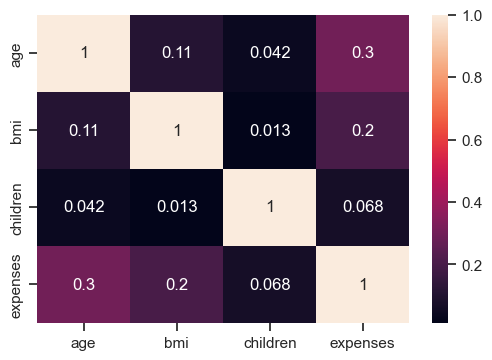

In [158]:
plt.figure(figsize=(6,4))
sns.heatmap(df.corr(numeric_only=True),annot=True)
plt.show()

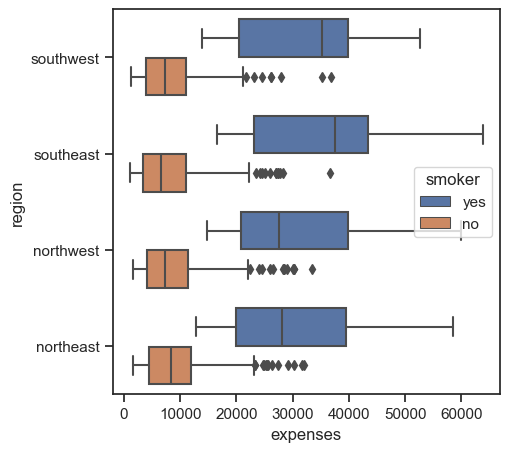

In [159]:
plt.figure(figsize=(5,5))
ax = sns.boxplot(x="expenses", y="region", hue = 'smoker',data=df)

- This shows that the data is very positively skewed for non-smokers and there might be some outliers in the data. 

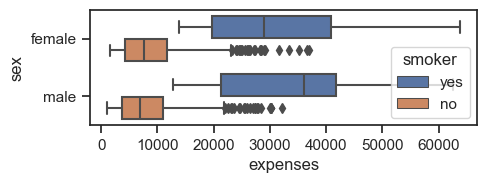

In [160]:
plt.figure(figsize=(5,1.5))
ax = sns.boxplot(x="expenses", y="sex",hue = 'smoker', data=df)

- The relationship between expenses and genders are similar and are positivety skewed 

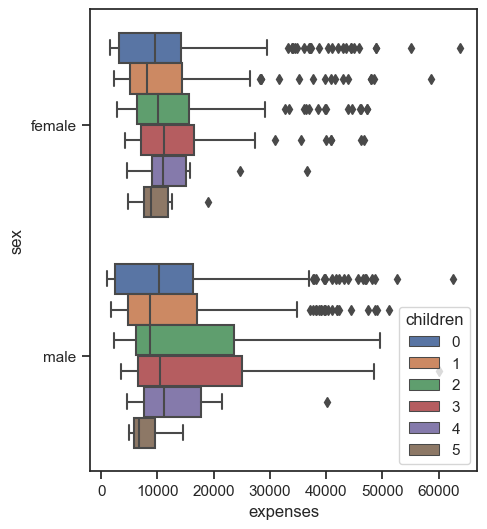

In [161]:
plt.figure(figsize=(5,6))
ax = sns.boxplot(x="expenses", y="sex",hue = 'children', data=df)

<Figure size 300x300 with 0 Axes>

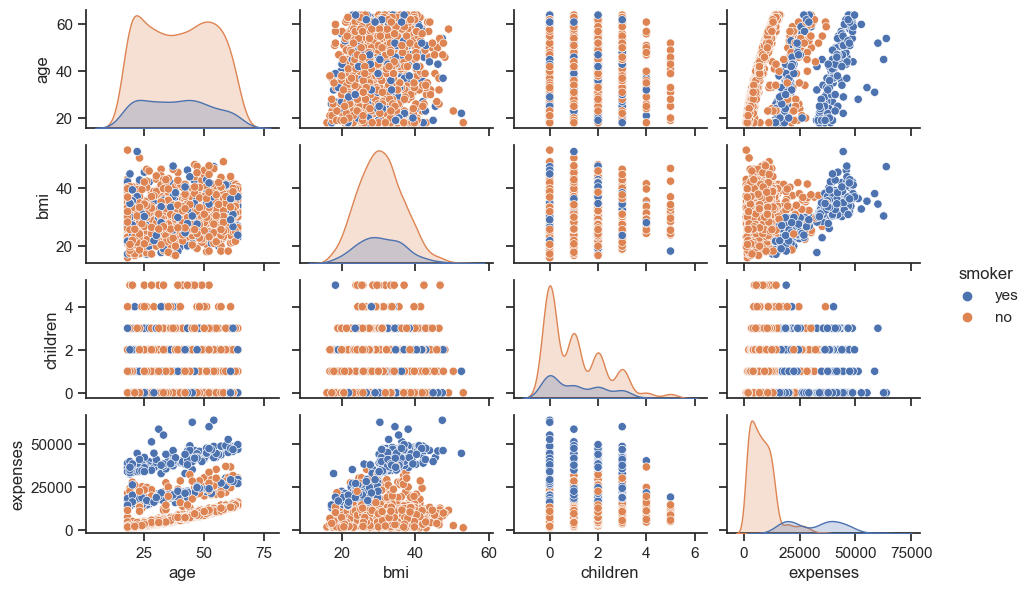

In [162]:
sns.set(style="ticks", color_codes=True)
plt.figure(figsize=(3,3))
g = sns.pairplot(df,height=1.5, aspect=1.6,hue="smoker")
plt.show()

#### Inference from the plot
- We could definitely see a trend that smokers tend to have higher medical insurance expenses from the *expenses distribution*
- No of children does not have much influence on the expenses 
- There is an increasing trend in expenses with ages in bands with the higher expenses mostly filled by the smokers. The spectrum of the three bands could be attributed to other factors in the expenses vs age graphs. 
- Smokers have a more uniform BMI distribution 
- BMI seems to have little correlation with expenses 

<Figure size 300x300 with 0 Axes>

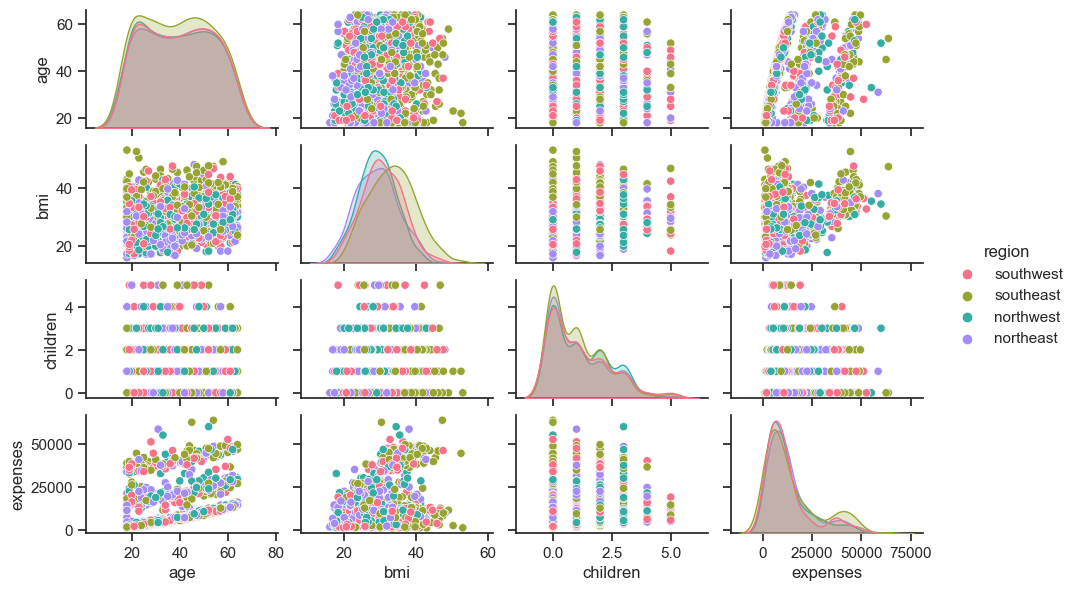

In [91]:
sns.set(style="ticks", color_codes=True)
plt.figure(figsize=(3,3))
g = sns.pairplot(df,height=1.5, aspect=1.6,hue="region",palette="husl")
plt.show()

#### Inference from the plot 
- Southeast region generally have a slight higher BMI and a slight higher insurance costs. 
- North-east region have slightly lower BMI annf generally lower expenses.
- The bands as observed in the expenses vs age graph could be somewhat attributed to the regions as South-east people tend to have the higher expenses while the lower bands mainly is filled  by the rest of the regions. 
- North-west region tend to have more children but the number of children have little to no effect on the expenses.
 

<Figure size 300x300 with 0 Axes>

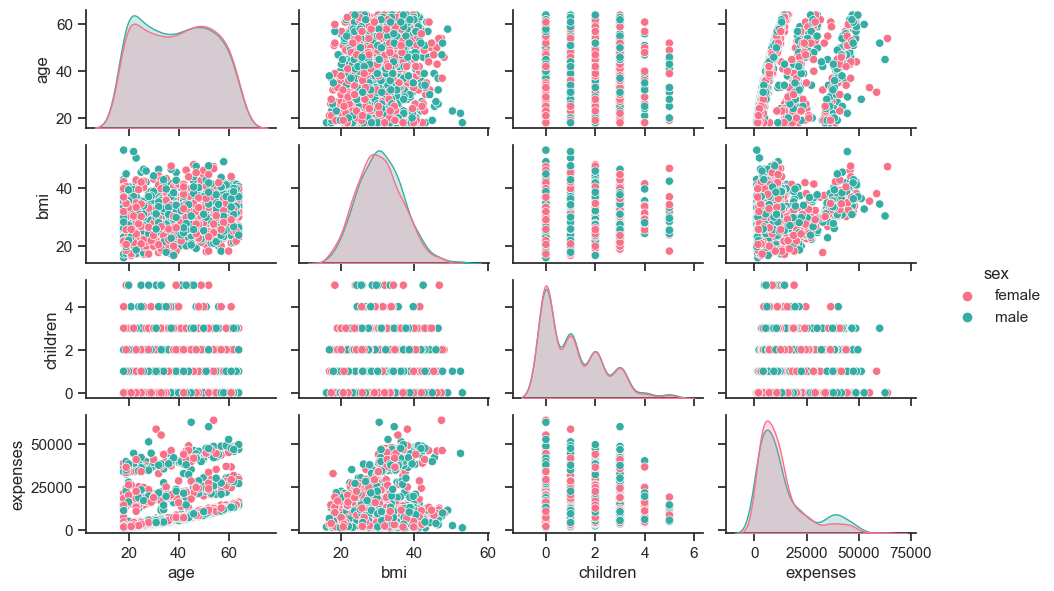

In [163]:
sns.set(style="ticks", color_codes=True)
plt.figure(figsize=(3,3))
g = sns.pairplot(df,height=1.5, aspect=1.6,hue="sex",palette="husl")
plt.show()

#### Inference from the plot 
- Males have a slight higher mean BMI than females
- The male expenses follows a bimodal distribution indicating higher expenses at the higher end than the females.  


### Factor Analysis of Mixed data (FAMD Analysis)

In [166]:
"Before performing FAMD analysis we want to normalize the quantitative dataset"
check = df.dtypes!='object'
quantitative_var = list(check[check].index)
# df[quantitative_var] = df[quantitative_var].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

df.head()

,age,sex,bmi,children,smoker,region,expenses
0,19,female,27.9,0,yes,southwest,16884.92
1,18,male,33.8,1,no,southeast,1725.55
2,28,male,33.0,3,no,southeast,4449.46
3,33,male,22.7,0,no,northwest,21984.47
4,32,male,28.9,0,no,northwest,3866.86


In [167]:
famd = FAMD(
     n_components=8,
     n_iter=10,
     copy=True,
     check_input=True,
     engine='sklearn')       ## Can be "auto", 'sklearn', 'fbpca'


df_y = df.drop('expenses', axis=1)

famd.fit(df_y)
famd.transform(df_y)

# famd.plot_row_coordinates(df_y,figsize=(15, 10),color_labels=['House Style : {}'.format(t) for t in df_y['smoker']] )

famd.eigenvalues_summary

,eigenvalue,% of variance,% of variance (cumulative)
component,,,
0,1.751,16.67%,16.67%
1,1.578,15.03%,31.70%
2,1.501,14.29%,45.99%
3,1.493,14.22%,60.21%
4,1.375,13.09%,73.30%
5,1.070,10.19%,83.50%
6,0.964,9.18%,92.67%
7,0.769,7.33%,100.00%


In [168]:
famd.column_coordinates_

component,0,1,2,3,4,5,6,7
variable,,,,,,,,
age,0.000151,0.014334,0.000370,0.000557,0.003018,0.622923,0.229953,0.128693
bmi,0.229640,0.117868,0.000003,0.003693,0.023575,0.084151,0.028123,0.512948
children,0.000034,0.000056,0.000778,0.014593,0.000296,0.309851,0.674390,0.000002
region,0.606574,0.502214,0.998111,0.660628,0.103066,0.030293,0.017208,0.081905
sex,0.157716,0.208519,0.001188,0.317319,0.311496,0.000600,0.000655,0.002507
smoker,0.249671,0.253117,0.000324,0.004689,0.483998,0.004576,0.002872,0.000752


### Inference from FAMD analysis 
- Almost all of the eigen components explain some of the variability of the data 
- Dimension reduction might not be an effective tool with this dataset 


### 02) Pre-processing the data 

In [178]:
'''Finding the number of categorical and quantitative variables'''

check_cat = (df.dtypes == 'object') 
categorical_var = list(check_cat[check_cat].index)

check_num = (df.dtypes != 'object') 
quantitative_var = list(check_num[check_num].index)

for cat_var in categorical_var:    
    unique_value = df[cat_var].unique()
    print (f'Number of categories in {cat_var} are: {len(unique_value)}, with categories as : {unique_value}')

Number of categories in sex are: 2, with categories as : ['female' 'male']
Number of categories in smoker are: 2, with categories as : ['yes' 'no']
Number of categories in region are: 4, with categories as : ['southwest' 'southeast' 'northwest' 'northeast']


In [192]:
"Identifying the multi-categories and the binary categories "
mult_cat = [] 
for id in categorical_var:
    if len(df[id].unique())>2:
        mult_cat.append(id)

bin_cat = [i for i in categorical_var if i not in mult_cat]

### Detecting outliers in the data 

- We calculate the Mahalanobis distance for the numerical features of the input DataFrame, and use it to detect outliers. We start by extracting the numerical data as a NumPy array, then calculating the covariance matrix and its inverse. We then use cdist to calculate the **Mahalanobis distance** for each sample, and calculate a threshold based on the mean and standard deviation of the distances
- We calculate the chi-squared test statistic for the categorical features of the input DataFrame, and use it to detect outliers. We iterate over each categorical column, and calculate the contingency table and the chi-squared test statistic using pd.crosstab and chi2_contingency. We then use np.where to find the indices of the outlier samples, and calculate a threshold based on the significance level (0.05) and the degrees of freedom (n_samples - 1).
- We combine the outlier indices from the distance-based method and the chi-squared test, and create a Pandas Series of boolean values indicating outlier samples. We use np.concatenate to combine the outlier indices
and return them by using the function *detect_outliers* below. 

In [170]:
from scipy.spatial.distance import cdist
from scipy.stats import chi2_contingency

def detect_outliers(df, n_std=3):
    """
    Detect outliers in mixed data using a combination of distance-based method and chi-squared test.
    df: Pandas DataFrame of shape (n_samples, n_features)
    n_std: number of standard deviations to use as threshold for distance-based method
    returns: Pandas Series of boolean values indicating outlier samples
    """
    # separate numerical and categorical features
    num_cols = df.select_dtypes(include=np.number).columns
    cat_cols = df.select_dtypes(exclude=np.number).columns
    
    # calculate Mahalanobis distance for numerical features
    num_data = df[num_cols].values
    cov = np.cov(num_data, rowvar=False)
    inv_cov = np.linalg.inv(cov)
    mahal_dist = cdist(num_data, np.mean(num_data, axis=0).reshape(1, -1), metric='mahalanobis', VI=inv_cov)
    num_threshold = np.mean(mahal_dist) + n_std * np.std(mahal_dist)
    num_outliers = np.where(mahal_dist > num_threshold)[0]
    
    # calculate chi-squared test statistic for categorical features
    cat_stats = []
    for col in cat_cols:
        contingency_table = pd.crosstab(df[col], df.index)
        chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)
        cat_stats.append(chi2_stat)
    cat_threshold = chi2.ppf(1 - 0.05, df=len(df.index) - 1)
    cat_outliers = np.where(cat_stats > cat_threshold)[0]
    
    # combine outlier indices from both methods
    outlier_indices = np.concatenate((num_outliers, cat_outliers))
    
    # create Pandas Series of boolean values indicating outlier samples
    outlier_mask = pd.Series(False, index=df.index)
    outlier_mask.iloc[outlier_indices] = True
    
    return outlier_mask

In [171]:
df_outlier_rm = df.loc[~detect_outliers(df, n_std=3.5)]
df_outlier_rm.reset_index(drop=True,inplace=True)

print ("We have removed {} outlier data-points from the data.".format(len(df)-len(df_outlier_rm)))

We have removed 6 outlier data-points from the data.


In [172]:
df_outlier_rm

,age,sex,bmi,children,smoker,region,expenses
0,19,female,27.9,0,yes,southwest,16884.92
1,18,male,33.8,1,no,southeast,1725.55
2,33,male,22.7,0,no,northwest,21984.47
3,32,male,28.9,0,no,northwest,3866.86
4,31,female,25.7,0,no,southeast,3756.62
...,...,...,...,...,...,...,...
1327,50,male,31.0,3,no,northwest,10600.55
1328,18,female,31.9,0,no,northeast,2205.98
1329,18,female,36.9,0,no,southeast,1629.83
1330,21,female,25.8,0,no,southwest,2007.95


In [193]:
onehot_enc = OneHotEncoder(drop='first') # Instead of one-hot encoder we use dummy encoder for binary variables to reduce the dimensions 
onehot_arr = onehot_enc.fit_transform(df_outlier_rm[bin_cat]).toarray()
onehot_df = pd.DataFrame(onehot_arr, columns=onehot_enc.get_feature_names_out(bin_cat))

df_mod  = pd.concat([df_outlier_rm.drop(bin_cat, axis=1), onehot_df], axis=1)

"One-hot encoder for muli-categories"
onehot_enc = OneHotEncoder() # Instead of one-hot encoder we use dummy encoder for binary variables to reduce the dimensions 
onehot_arr = onehot_enc.fit_transform(df_outlier_rm[mult_cat]).toarray()
onehot_df = pd.DataFrame(onehot_arr, columns=onehot_enc.get_feature_names_out(mult_cat))
df_mod  = pd.concat([df_mod.drop(mult_cat, axis=1), onehot_df], axis=1)

df_mod.to_csv('00_Data/processed_data.csv',index=False)

df_mod.head()


,age,bmi,children,expenses,sex_male,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.9,0,16884.92,0.0,1.0,0.0,0.0,0.0,1.0
1,18,33.8,1,1725.55,1.0,0.0,0.0,0.0,1.0,0.0
2,33,22.7,0,21984.47,1.0,0.0,0.0,1.0,0.0,0.0
3,32,28.9,0,3866.86,1.0,0.0,0.0,1.0,0.0,0.0
4,31,25.7,0,3756.62,0.0,0.0,0.0,0.0,1.0,0.0


In [175]:
onehot_enc.get_feature_names_out(categorical_var)

array(['sex_male', 'smoker_yes', 'region_northwest', 'region_southeast',
       'region_southwest'], dtype=object)

In [176]:
df_mod

,age,bmi,children,expenses,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.9,0,16884.92,0.0,1.0,0.0,0.0,1.0
1,18,33.8,1,1725.55,1.0,0.0,0.0,1.0,0.0
2,33,22.7,0,21984.47,1.0,0.0,1.0,0.0,0.0
3,32,28.9,0,3866.86,1.0,0.0,1.0,0.0,0.0
4,31,25.7,0,3756.62,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...
1327,50,31.0,3,10600.55,1.0,0.0,1.0,0.0,0.0
1328,18,31.9,0,2205.98,0.0,0.0,0.0,0.0,0.0
1329,18,36.9,0,1629.83,0.0,0.0,0.0,1.0,0.0
1330,21,25.8,0,2007.95,0.0,0.0,0.0,0.0,1.0
